# Predicting Membership Renewals

### Introduction 
#### The following project goes over the design of a model that attempts to predict membership renewal at the Museum of Modern Art in order to minimize "churn", and predict future income and expenditure for member acquisition. 
The cost of acquiring new members at MoMA is far higher than retention, but it is difficult to identify members that are at risk of non-renewal. Currently 34% of the member base don't renew. To be able to do so in time to take some action that might tip the balance, could save the Museum money by preventing the loss of a paying member.

MoMA sends out anywhere between one and ten renewal notices by mail per member, to roughly 95% of those members up for renewal, and sends the same number of emails to the other 5% (student and artist members). At 93.2 cents per mail piece and only 0.02 cents per email, identifying probability of renewal per member could save the Museum money by recommending the cheaper method to those less likely to respond favorably. Of course, this method runs the risk of sending just an e-mail to members that might respond better to a regular mail piece. For this reason, a model that optimizes for a good area under the curve (AUC) score might be preferable.

### Problem
Using data on membership periods (contracts) completed between January 1, 2006 and December 31, 2015, derived from MoMA's CRM system Salesforce combined with the door-entry system scan file, this project aims to determine if it is possible to predict if a member will renew at the end of a given contract, based on their use of member benefits (free entry, $5 guest tickets, and store discount) during that contract, and the level and length of their membership.

#### Importing the code packages and csv file.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
import sklearn.linear_model as lm
from sklearn import dummy, metrics
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn import grid_search, cross_validation

#file_in = (r'../../00-assets/Membership_Files/members.csv')
file_in = (r'members.csv')
members = pd.read_csv(file_in)

### Data Library

Variable | Description | Type of Variable | dtype
:---| :---| ---| ---
ID | Unique identifier of each individual member | categorical | float64
Member_Year | Year of membership | continuous | float64
Year_Group | Year of membership group, 15 years and over grouped as 15+ | categorical | float64
Category | Category of member: e.g. Individual, Student | categorical | object
Value | The amount paid for the membership | continuous | float64
Scanned_Visits | Scans of membership cards | continuous | float64
No_Card_Visits | Member-without-card tickets issued | continuous | float64
Film_Visits | Members film screening bookings | continuous | float64
All_Visits | Total of member scans, without card tickets, and film | continuous | float64
Regular_Guests | Member guest tickets sold | continuous | float64
Film_Guests | Member guest film tickets sold | continuous | float64
All_Paying_Guests | Total guest ticket sales | continuous | float64
Guest_Value | Dollar value of guest ticket sales | continuous | float64
Scanned_Guests | Free guests of high level members | continuous | float64
Promo_Guests | Free guests during promotions | continuous | float64
All_Free_Guests | Total free guests | continuous | float64
All_Guests | Paying plus free guests | continuous | float64
Store_Trans | Number of store transactions | continuous | float64
Store_Discount | Amount of store discount received (negative if refund) | continuous | float64
Amount | Amount of store sales before discount | continuous | float64
Net | Net profit on store sales to members (sale amount / 2 - discount) | continuous | float64
Member_Value | Total of amount paid for membership, paying guests, and net profit | continuous | float64
Renewed | Dependent variable: renewed = 1, not-renewed = 0 | binary | float64
Artist | Dummy variable for membership category | binary | float64
Benefactor | Dummy variable for membership category | binary | float64
Dual | Dummy variable for membership category | binary | float64
Family | Dummy variable for membership category | binary | float64
Fellow | Dummy variable for membership category | binary | float64
Global | Dummy variable for membership category | binary | float64
Indivdual | Dummy variable for membership category | binary | float64
Major Benefactor | Dummy variable for membership category | binary | float64
Other | Dummy variable for membership category | binary | float64
Patron | Dummy variable for membership category | binary | float64
Student | Dummy variable for membership category | binary | float64
Supporting | Dummy variable for membership category | binary | float64
Sustaining | Dummy variable for membership category | binary | float64
Sustaining Benefactor | Dummy variable for membership category | binary | float64

### Distribution of Variables
When plotted against renewal rate, year of membership shows a clear logarithmic relationship. The first job is to do a log transformation on Member Year for inclusion in the model.

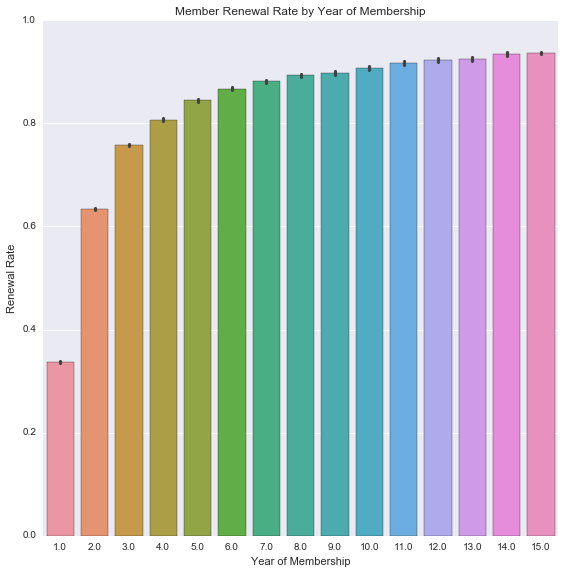

In [4]:
bar = sns.factorplot(x='Year_Group', 
              y='Renewed',
              kind='bar',
              data = members,
              size = 8,
            )
bar.set(xlabel='Year of Membership', ylabel='Renewal Rate', title='Member Renewal Rate by Year of Membership')

The main benefit of membership is unlimited free admission. This is record as the Scanned_Visits variable. Probability of renewal increases with each visit up to the 10th, then starts to level off. A log transformation was also performed on this field for testing in the model.

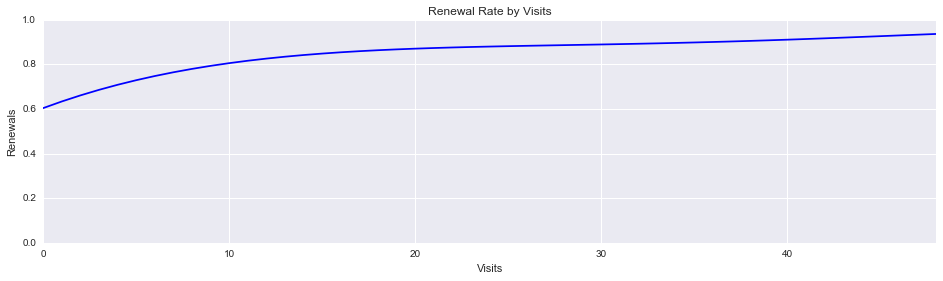

In [31]:
table = members.pivot_table(values=['Renewed'], index=['Scanned_Visits'], aggfunc=np.mean)
table.fillna(1,inplace=True)
plt.figure(figsize=(16,4))
plt.ylim(0,1)
plt.xlim(0,table.index.max())

x = table.index
y = table['Renewed']
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
pl.plot(x,p(x), "b-")

plt.title('Renewal Rate by Visits')
plt.xlabel('Visits')
plt.ylabel('Renewals')

Members also get to bring guests for $5.00. The Regular_Guests field shows a more complex relationship with the Renewal outcome, since for some members, buying a membership and x guest tickets is cheaper than buying x + 1 admission tickets.

Such members receive the full value of their membership on the first visit and renewal is less likely as a result. Such activity is referred to as opportunism. By identifying members who have visited once only and who's spend on their membership plus guest tickets was less than admission tickets would have been, it was possible to create an Opportunism field for use in the model.

After a certain number of guest tickets the probability of renewal increases again until about 12 guest tickets when it levels off again. A log transformation was also performed on this field.

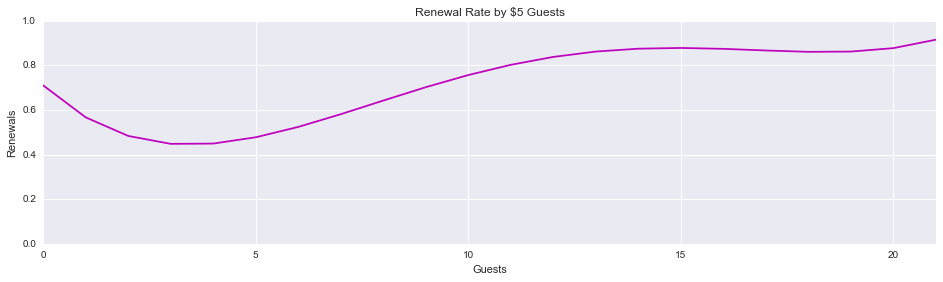

In [32]:
table = members.pivot_table(values=['Renewed'], index=['Regular_Guests'], aggfunc=np.mean)
table.fillna(1,inplace=True)
plt.figure(figsize=(16,4))
plt.ylim(0,1)
plt.xlim(0,table.index.max())

x = table.index
y = table['Renewed']
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
pl.plot(x,p(x), "m-")

plt.title('Renewal Rate by $5 Guests')
plt.xlabel('Guests')
plt.ylabel('Renewals')

Renewal rate appears to go down slightly with every dollar received in store discount until the $100.00 range when it improves slightly. A log transformation was also performed on the Store_Discount field.

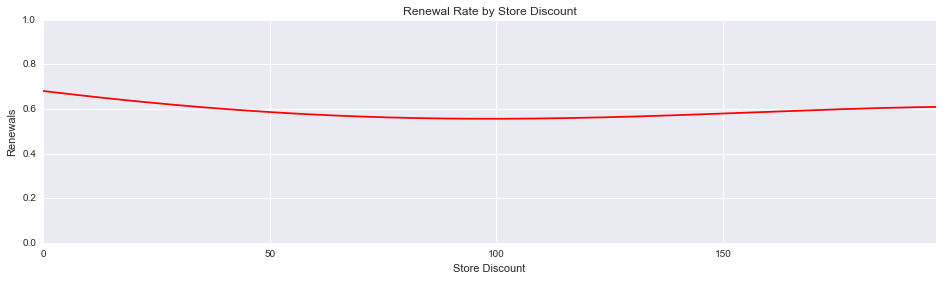

In [33]:
table = members.pivot_table(values=['Renewed'], index=['Store_Discount'], aggfunc=np.mean)
table.fillna(1,inplace=True)
plt.figure(figsize=(16,4))
plt.ylim(0,1)
plt.xlim(0,table.index.max())

x = table.index
y = table['Renewed']
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
pl.plot(x,p(x), "r-")

plt.title('Renewal Rate by Store Discount')
plt.xlabel('Store Discount')
plt.ylabel('Renewals')

There is a lot of variation in renewal rate for the membership category field. Category is clearly a significant factor in Renewal rates.

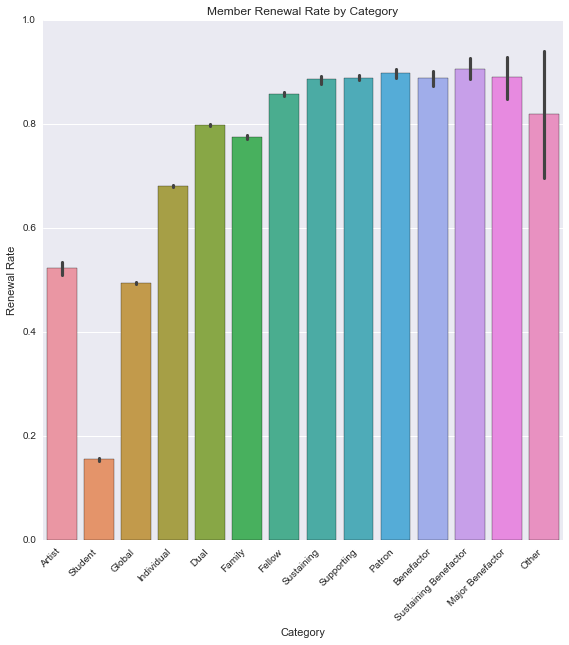

In [30]:
x_order = ['Artist','Student','Global','Individual','Dual','Family','Fellow','Sustaining',
           'Supporting','Patron','Benefactor','Sustaining Benefactor','Major Benefactor','Other']
bar = sns.factorplot(x='Category', 
              y='Renewed',
              kind='bar',
              data = members,
              size = 8,
              order = x_order
            )
bar.set_xticklabels(rotation=45, horizontalalignment='right')
bar.set(xlabel='Category', ylabel='Renewal Rate', title='Member Renewal Rate by Category')

### Testing Variables in Different Models
I began by testing the Logit model on different combinations of the variables and their log-transformed versions. Some fields are also aggregates of other fields (All_Visits aggregates Scanned_Visits, No_Card_Visits, and Film_Visits) and so tested models also alternated between aggregated and disaggregated fields.

It was clear from model 3 onwards that Log_Year was much more effective than Member_Year, so from that point on, it was used exclusively. Log transformed versions of other variables were far less effective and often led to higher p-values and confidence intervals that contained zero.

Model 16 included the Opportunism variable (opportunistic behaviour = 1, otherwise = 0) discussed above, but although this improved accuracy, not only did accuracy still round (down) to 0.77, precision and AUC were affected negatively.

Ultimately, model 4 performed best on precision and AUC, accuracy was still acceptable and p-values were all comfortably below 0.05. Although this model used the disaggregated versions of the visits, paying guests and free guest fields, it is simplified by having no log transformed variables other than Log_Year.

This chart summarizes variables tested in each model and the relative p-values.

Variables and p-values by Model| 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16
:----------------------|--:|--:|--:|--:|--:|--:|--:|--:|--:|---:|---:|---:|---:|---:|---:|---:
Member_Year            |0.00|0.00||||||||||||||
Log_Year               |||0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00
Scanned_Visits         ||0.00||0.00||||0.00||0.00||0.00||||0.00
Log_Scanned_Visits     ||||||0.00|||||||0.00|0.00|0.00|
Scanned_Zero           ||||||0.00|||||||0.13|0.00|0.00|
No_Card_Visits         ||0.00||0.00||||0.00||0.00||0.00|0.00|0.00|0.00|0.00
Log_No_Card_Visits     ||||||0.00||||||||||
No_Card_Zero           ||||||0.01||||||||||
Film_Visits            ||0.01||0.00||||0.00||0.00||0.02|0.00|0.00|0.00|0.00
Log_Film_Visits        ||||||0.36||||||||||
Film_Visits_Zero       ||||||0.01||||||||||
All_Visits             |0.00||0.00||||0.00||0.00||0.00|||||
Log_All_Visits         |||||0.00|||||||||||
No_Visits              |||||0.00|||||||||||
Regular_Guests         ||0.00||0.00||0.00||||0.00||0.93||0.00|0.00|0.00
Log_Regular_Guests     ||||||||0.00|||||0.00|||
Regular_Guests_Zero    ||||||||0.00|||||0.00|||
Film_Guests            ||0.00||0.01||0.02||||0.01||0.01|0.01|0.04|0.04|0.07
Log_Film_Guests        ||||||||0.00||||||||
Film_Guests_Zero       ||||||||0.25||||||||
All_Paying_Guests      |0.00||0.74||0.01||||0.70||0.00|||||
Log_All_Paying_Guests  |||||||0.00|||||||||
No_Paying_Guests       |||||||0.00|||||||||
Scanned_Guests         ||0.01||0.00||0.10||0.02||||0.01|0.44||0.10|0.00
Log_Scanned_Guests     ||||||||||0.28||||0.46||
Scanned_Guests_Zero    ||||||||||0.06||||0.33||
Promo_Guests           ||0.00||0.00||0.00||0.00||||0.00|0.00|0.00|0.00|0.00
Log_Promo_Guests       ||||||||||0.50||||||
Promo_Guests_Zero      ||||||||||0.00||||||
All_Free_Guests        |0.00||0.00||0.00||0.00||||0.00|||||
Log_All_Free_Guests    |||||||||0.00|||||||
No_Free_Guests         |||||||||0.00|||||||
Store_Discount         |0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|0.00|||0.00|0.00|0.00|0.00
Log_Store_Discount     |||||||||||0.29|0.25||||
No_Discount            |||||||||||0.00|0.00||||
Opportunism            ||||||||||||||||0.00

Key Model Performance Scores.| 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16
:----------------------|--:|--:|--:|--:|--:|--:|--:|--:|--:|---:|---:|---:|---:|---:|---:|---:
Area Under Curve       |0.70|0.70|0.73|0.73|0.73|0.73|0.73|0.73|0.73|0.73|0.73|0.73|0.73|0.73|0.73|0.73
Precision              |0.78|0.78|0.81|0.81|0.81|0.81|0.81|0.81|0.81|0.81|0.81|0.81|0.81|0.81|0.81|0.81
Accuracy               |0.76|0.75|0.77|0.77|0.77|0.77|0.77|0.77|0.77|0.77|0.77|0.77|0.77|0.77|0.77|0.77

### Logit Model
#### Saving just Model-4 variables to the test DataFrame.

In [2]:
cols_to_keep = ['Log_Year', 'Member_Year', 'Category', 'Scanned_Visits', 'No_Card_Visits', 'Film_Visits', 'Regular_Guests', 'Film_Guests',
                'Scanned_Guests', 'Promo_Guests', 'Store_Discount', 'Renewed', 'Artist', 'Benefactor',
                'Dual', 'Family', 'Fellow', 'Global', 'Individual', 'Major Benefactor',
                'Other', 'Patron', 'Supporting', 'Sustaining', 'Sustaining Benefactor']
member_data = members[cols_to_keep]
member_data.head()

,Log_Year,Member_Year,Category,Scanned_Visits,No_Card_Visits,Film_Visits,Regular_Guests,Film_Guests,Scanned_Guests,Promo_Guests,...,Family,Fellow,Global,Individual,Major Benefactor,Other,Patron,Supporting,Sustaining,Sustaining Benefactor
0,2.944439,19,Individual,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2.890372,18,Individual,2,1,0,2,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2.833213,17,Individual,2,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2.772589,16,Individual,3,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,2.708050,15,Individual,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### Adding the intercept for use in logistic regression

In [3]:
member_data['Intercept'] = 1.0

/Users/keiththompson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Setting the covariates to training columns variable
Note: The Student category of membership is used as the reference.

In [4]:
train_cols = ['Log_Year', 'Scanned_Visits', 'No_Card_Visits', 'Film_Visits', 'Regular_Guests', 'Film_Guests',
                'Scanned_Guests', 'Promo_Guests', 'Store_Discount', 'Artist', 'Benefactor',
                'Dual', 'Family', 'Fellow', 'Global', 'Individual', 'Major Benefactor',
                'Other', 'Patron', 'Supporting', 'Sustaining', 'Sustaining Benefactor', 'Intercept']

#### Fitting the Logit model

In [67]:
logit_model = sm.Logit(member_data['Renewed'], member_data[train_cols])

model = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.494106
         Iterations 7


In [18]:
print model.summary()

                           Logit Regression Results                           
Dep. Variable:                Renewed   No. Observations:              1023460
Model:                          Logit   Df Residuals:                  1023437
Method:                           MLE   Df Model:                           22
Date:                Wed, 16 Mar 2016   Pseudo R-squ.:                  0.2310
Time:                        14:35:03   Log-Likelihood:            -5.0570e+05
converged:                       True   LL-Null:                   -6.5762e+05
                                        LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Log_Year                  1.2166      0.003    371.158      0.000         1.210     1.223
Scanned_Visits            0.0747      0.001     82.543      0.000         0.073     0.077
No_Card_

#### Model Summary
As noted above, the p-values of each variable suggest that they are significant when explaining renewal rate, and the associated confidence intervals don't include zero.

Disaggregating visits and guests show that while Scanned_Visits and No_Card_Visits tend to improve renewal rates, Film_Visits have the opposite effect. Similarly, Regular_Guest sales tend to decrease the probability of renewal, Scanned_Guests and Promo_Guests improve it.

#### Taking the exponent of each coefficient to show the odds ratios for each variable.
Being a Patron member is the best predictor of renewal since Patrons have 8 times the odds of renewing as the Student reference category (controlling for number of visits, guests, store discount and year of membership).
Film_Visits and Regular_Guests ticket sales, and Store_Discount have the greatest effect on non-renewal. This can potentially be explained by Opportunistic behaviour leading to a member getting all the benefit of membership in one visit and not returning.

In [19]:
results = np.exp(model.conf_int())
results['OR'] = np.exp(model.params)
results.columns = ['2.5%', '97.5%', 'OR']
print results

                           2.5%      97.5%        OR
Log_Year               3.353942   3.397314  3.375558
Scanned_Visits         1.075686   1.079510  1.077596
No_Card_Visits         1.173472   1.197791  1.185569
Film_Visits            0.973626   0.993479  0.983502
Regular_Guests         0.990385   0.996293  0.993335
Film_Guests            1.006070   1.045453  1.025572
Scanned_Guests         1.012868   1.071312  1.041680
Promo_Guests           1.405763   1.596411  1.498057
Store_Discount         0.997161   0.997671  0.997416
Artist                 2.326891   2.635102  2.476206
Benefactor             5.420511   7.490412  6.371959
Dual                   6.032907   6.394746  6.211193
Family                 6.100803   6.547696  6.320301
Fellow                 7.289275   7.904315  7.590568
Global                 3.328901   3.519942  3.423089
Individual             5.087860   5.372917  5.228446
Major Benefactor       4.073019  10.006781  6.384184
Other                  1.437143  10.219252  3.

#### The Member_Year odds ratio is calculated differently though.

In [20]:
result = pd.DataFrame(model.conf_int().ix[0]).T
result['OR'] = model.params.ix[0]
result.columns = ['2.5%', '97.5%', 'OR']
print result

              2.5%     97.5%        OR
Log_Year  1.210137  1.222985  1.216561


### LogisticRegression Model
#### Optimizing the model parameters for best AUC score.
The grid_search.GridSearchCV function was used to iterate through a parameter variations and find the best estimator for a high area under curve score. C=100 and class_weight=None were returned.

In [21]:
feature_set = member_data[train_cols]
gs = grid_search.GridSearchCV(
    estimator=lm.LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-3, 3)],
                'class_weight': [None, 'balanced']},
    cv=cross_validation.KFold(n=len(member_data), n_folds=5),
    scoring='roc_auc')


gs.fit(feature_set, member_data.Renewed)
#gs.grid_scores_
print gs.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


#### Fitting the LogisticRegression model.

In [5]:
model1 = lm.LogisticRegression(C=100)
model1_fit = model1.fit(member_data[train_cols], member_data['Renewed'])

#### Calculating the odds ratios.

In [23]:
def odds_ratios(features,coefficients):
    x = 0
    while x < len(features)-1:
        print '%1.4f' % coefficients[0][x], features[x]
        x += 1
    print '\n%1.4f Intercept' % np.exp(model1.intercept_)[0]
    print '%1.4f Mean' % member_data.Renewed.mean()

In [24]:
odds_ratios(train_cols,np.exp(model1.coef_))

3.3756 Log_Year
1.0776 Scanned_Visits
1.1856 No_Card_Visits
0.9835 Film_Visits
0.9933 Regular_Guests
1.0256 Film_Guests
1.0417 Scanned_Guests
1.4980 Promo_Guests
0.9974 Store_Discount
2.4761 Artist
6.3716 Benefactor
6.2096 Dual
6.3205 Family
7.5900 Fellow
3.4224 Global
5.2274 Individual
5.8530 Major Benefactor
3.2856 Other
8.1403 Patron
7.9213 Supporting
7.6669 Sustaining
7.4721 Sustaining Benefactor

0.3429 Intercept
0.6577 Mean


#### Again odds ratio for Member_Year is calculated differently.

In [25]:
print '%1.4f Member_Year' % model1.coef_[0][0]

1.2166 Member_Year


### Key Model Scores
#### Starting by predicting renewal outcome with .predict_proba function.

In [6]:
member_data['Probability'] = model1.predict_proba(member_data[train_cols]).T[1]

/Users/keiththompson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Receiver Operation Characteristic (ROC) curve.
The model was optimized for area under curve score and returns a value of 0.73302.

[(0, 1),
 (0, 1),

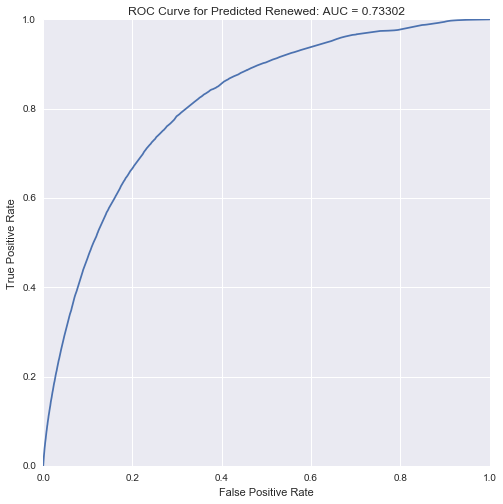

In [7]:
actuals = model1.predict(member_data[train_cols])
Model_AUC = roc_auc_score(member_data['Renewed'], actuals)

fig, ax = plt.subplots(1,1,figsize = (8, 8))
vals = metrics.roc_curve(member_data.Renewed, member_data.Probability)
ax.plot(vals[0], vals[1])
ax.set(title='ROC Curve for Predicted Renewed: AUC = %1.5f' % Model_AUC,
       ylabel='True Positive Rate', xlabel='False Positive Rate', xlim=(0, 1), ylim=(0, 1))

#### All the models that included Log_Year returned an accuracy that rounded to 0.77.

In [8]:
Model_Accuracy = model1.score(member_data[train_cols],member_data['Renewed'])
Model_Accuracy

0.76752388955113049

#### Accuracy Compared to Previous Studies - [Modeling Churn](http://www8.gsb.columbia.edu/ideas-at-work/publication/1573)
In February 2013, Eva Ascarza of Columbia Business School, and Bruce G. S. Hardie of London Business School, produced a paper on _A Joint Model of Usage and Churn in Contractual Settings_. This was a study that created a model to predict future revenue from active customers in a sample organization's membership scheme. Their study used a combination of modeling and estimation techniques, and attempted to detect who would be the most valuable customers in the long run. The model identified customers at risk of not renewing a membership by observing changes in how much a customer uses a product or service as a contract expiry date approaches. 

By not aggregating data over a year's contract and focusing on changes in usage as an expiry date approaches this could indicate if a user was just getting the final use of benefits before allowing their membership to expire, or alternatively increasing their commitment to the organization. The model aimed to classify customers on the basis of this commitment. The authors report a 97% accuracy in predicting usage (see table on left below), compared with anywhere between the 54% and 88% accuracy of other models.

![](Accuracy_of_Usage_Predictions_2.png)

From A Joint Model of Usage and Churn in Contractual Settings - 'Full Specification' refers to the model in the study.

Benchmark models compared in above table: Agg % Error in predicting revenue.
- RFM (recency, frequency, monetary value) methods widely used among researchers and practitioners.
 - The cross-sectional model used data from year n to predict data from period n + 1. (+26%)
 - The panel model used data from year 1 to n to predict data from period n + 1. (+136%)
- A bivariate econometric model that jointly estimates submodels for the two behaviors of interest.
 - This model assumes two latent variables where one variable determines usage and the other determines retention, it then allows these two variables to be correlated in order to capture possible dependencies between usage and renewal behaviors. (-46%)
- Two restricted versions of their own dynamic latent variable model.
 - A homogeneous usage model in which the members of each commitment state have the same expected purchase behavior. (-2%)
 - A homogeneous transition model where the state transition probabilities are the same for all individuals. (-12%)

A major problem with some of these models is that they cannot automatically be used to forecast customer behavior multiple periods into the future, since they rely on recent data. My model attempts to get around this problem by stratifying the data on the contract level, thus creating a year of membership field.

An accuracy of 77% compares quite well with some of the other studies done on this subject, but it is clear that improvements could be made by accounting for certain other activities. In the above model that means membership usage in the weeks preceding membership expiration, but with my model this could be activity on day of purchase. See below for suggested improvements.

#### Precision and Recall are both returned by the precision_recall_curve function.
The model returns a precision score of 0.81134 and recall of 0.84242.

[(0, 1),
 (0, 1),

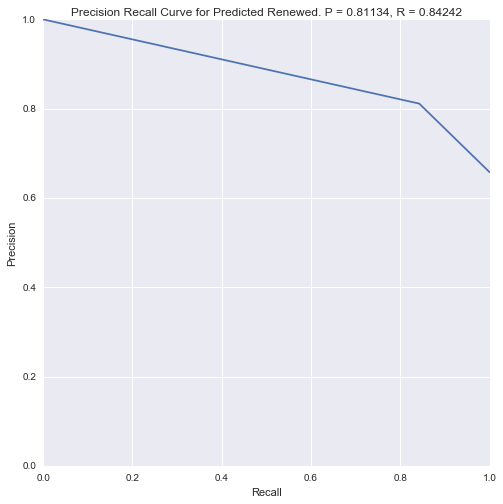

In [9]:
precision, recall, thresholds = precision_recall_curve(member_data['Renewed'], actuals)
Model_Precision = precision[1]
Model_Recall = recall[1]

fig, ax = plt.subplots(1,1,figsize = (8, 8))
ax.plot(recall, precision)
ax.set(title='Precision Recall Curve for Predicted Renewed. P = %1.5f, R = %1.5f' % (Model_Precision, Model_Recall),
       ylabel='Precision', xlabel='Recall', xlim=(0, 1), ylim=(0, 1))

#### Optimizing model for best reference dummy variable.
By writing a function that iterates through categories of member using each in turn as the reference, I wanted to see if any of the model scores could be noteably improved by using a different reference. Student is still a suitable reference.

In [32]:
member_data2 = member_data.join(members['Student'])
features = train_cols + ['Student']
categories = ['Artist', 'Benefactor', 'Dual', 'Individual', 'Family', 'Fellow', 'Global', 'Major Benefactor',
                'Other', 'Patron', 'Student', 'Supporting', 'Sustaining', 'Sustaining Benefactor']
for cat in categories:
    model = lm.LogisticRegression(C=100)
    X = member_data2[features]
    X.drop(cat, axis=1, inplace=True)
    model.fit(X, member_data2['Renewed'])
    actuals = model.predict(X)
    AUC = roc_auc_score(member_data2['Renewed'], actuals)
    Accuracy = model.score(X,member_data2['Renewed'])
    precision, recall, thresholds = precision_recall_curve(member_data2['Renewed'], actuals)
    pre = precision[1]
    rec = recall[1]
    print ('Accuracy: %1.5f, AUC: %1.5f, Precision: %1.5f, Recall: %1.5f') %(Accuracy, AUC, pre, rec), cat

Accuracy: 0.76753, AUC: 0.73302, Precision: 0.81135, Recall: 0.84242 Artist
Accuracy: 0.76753, AUC: 0.73302, Precision: 0.81135, Recall: 0.84242 Benefactor
Accuracy: 0.76753, AUC: 0.73302, Precision: 0.81135, Recall: 0.84242 Dual
Accuracy: 0.76753, AUC: 0.73302, Precision: 0.81135, Recall: 0.84242 Individual
Accuracy: 0.76753, AUC: 0.73305, Precision: 0.81138, Recall: 0.84236 Family
Accuracy: 0.76753, AUC: 0.73302, Precision: 0.81135, Recall: 0.84243 Fellow
Accuracy: 0.76753, AUC: 0.73302, Precision: 0.81135, Recall: 0.84242 Global
Accuracy: 0.76753, AUC: 0.73302, Precision: 0.81135, Recall: 0.84242 Major Benefactor
Accuracy: 0.76753, AUC: 0.73305, Precision: 0.81138, Recall: 0.84236 Other
Accuracy: 0.76752, AUC: 0.73302, Precision: 0.81134, Recall: 0.84242 Patron
Accuracy: 0.76752, AUC: 0.73302, Precision: 0.81134, Recall: 0.84242 Student
Accuracy: 0.76753, AUC: 0.73302, Precision: 0.81135, Recall: 0.84242 Supporting
Accuracy: 0.76753, AUC: 0.73302, Precision: 0.81134, Recall: 0.84242

/Users/keiththompson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Optimizing to determine if any variable should be dropped from the model.
By writing a function that iterates through each other variable, dropping each in turn, I wanted to see if dropping any variable noteably improved any of the model scores. Some miniscule improvement is possible, but nothing significant.

In [33]:
feature_set = ['Log_Year', 'Scanned_Visits', 'No_Card_Visits', 'Film_Visits', 'Regular_Guests', 'Film_Guests',
                'Scanned_Guests', 'Promo_Guests', 'Store_Discount']
for feat in feature_set:
    model = lm.LogisticRegression(C=100)
    X = member_data2[train_cols]
    X.drop(feat, axis=1, inplace=True)
    model.fit(X, member_data2['Renewed'])
    actuals = model.predict(X)
    AUC = roc_auc_score(member_data2['Renewed'], actuals)
    Accuracy = model.score(X,member_data2['Renewed'])
    precision, recall, thresholds = precision_recall_curve(member_data2['Renewed'], actuals)
    pre = precision[1]
    rec = recall[1]
    print ('Accuracy: %1.5f, AUC: %1.5f, Precision: %1.5f, Recall: %1.5f') %(Accuracy, AUC, pre, rec), feat

Accuracy: 0.69674, AUC: 0.60772, Precision: 0.71713, Recall: 0.88995 Log_Year
Accuracy: 0.76605, AUC: 0.73355, Precision: 0.81311, Recall: 0.83658 Scanned_Visits
Accuracy: 0.76599, AUC: 0.73142, Precision: 0.81036, Recall: 0.84103 No_Card_Visits
Accuracy: 0.76755, AUC: 0.73301, Precision: 0.81132, Recall: 0.84251 Film_Visits
Accuracy: 0.76706, AUC: 0.73222, Precision: 0.81065, Recall: 0.84266 Regular_Guests
Accuracy: 0.76752, AUC: 0.73302, Precision: 0.81135, Recall: 0.84240 Film_Guests
Accuracy: 0.76751, AUC: 0.73305, Precision: 0.81139, Recall: 0.84231 Scanned_Guests
Accuracy: 0.76740, AUC: 0.73292, Precision: 0.81130, Recall: 0.84223 Promo_Guests
Accuracy: 0.76672, AUC: 0.73347, Precision: 0.81252, Recall: 0.83888 Store_Discount


/Users/keiththompson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Validation
#### Cross-validation
Using a 10 fold model I used cross-validation and compared the model scores to the 10 fold mean. Each cross-validated score is very close to the original model scores.

In [34]:
model_data = member_data[train_cols]
y = member_data.Renewed

kf = cross_validation.KFold(len(model_data), n_folds=10, shuffle=True)
Accuracy = []
AUC_ = []
Precision = []
Recall = []
for train_index, test_index in kf:
    model = lm.LogisticRegression(C=100).fit(model_data.iloc[train_index], y.iloc[train_index])
    actuals = model.predict(model_data.iloc[test_index])
    AUC = roc_auc_score(y.iloc[test_index], actuals)
    precision, recall, thresholds = precision_recall_curve(y.iloc[test_index], actuals)
    pre = precision[1]
    rec = recall[1]
    Accuracy.append(model.score(model_data.iloc[test_index],y.iloc[test_index]))
    Precision.append(pre)
    Recall.append(rec)
    AUC_.append(AUC)
    
print ('Accuracy: %1.5f, AUC: %1.5f, Precision: %1.5f, Recall: %1.5f (Model)') % (Model_Accuracy, Model_AUC, Model_Precision, Model_Recall)
print ('Accuracy: %1.5f, AUC: %1.5f, Precision: %1.5f, Recall: %1.5f (Cross_Validated)') % (np.mean(Accuracy), np.mean(AUC_), np.mean(Precision), np.mean(Recall))

Accuracy: 0.76752, AUC: 0.73302, Precision: 0.81134, Recall: 0.84242 (Model)
Accuracy: 0.76751, AUC: 0.73309, Precision: 0.81145, Recall: 0.84222 (Cross_Validated)


#### Dummy Classifier

[(0, 1),
 (0, 1),

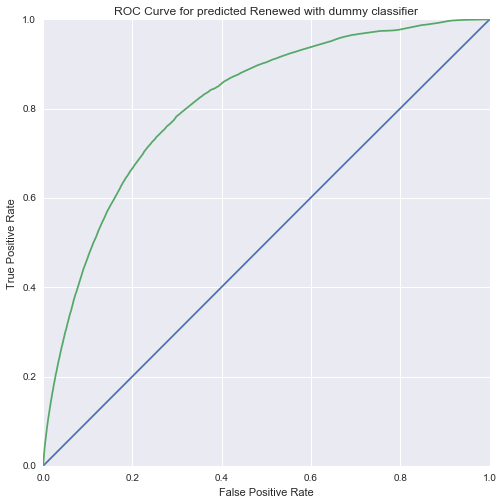

In [63]:
member_test = member_data.copy()

dummy_model = dummy.DummyClassifier()
dummy_model.fit(member_test[train_cols], member_test['Renewed'])
member_test['probability_0'] = dummy_model.predict_proba(member_test[train_cols]).T[1]

actual_model = lm.LogisticRegression()
actual_model.fit(member_test[train_cols], member_test['Renewed'])
member_test['probability_1'] = actual_model.predict_proba(member_test[train_cols]).T[1]

fig, ax = plt.subplots(1,1,figsize = (8, 8))
vals = metrics.roc_curve(member_test.Renewed, member_test.probability_0)
ax.plot(vals[0], vals[1])
vals = metrics.roc_curve(member_test.Renewed, member_test.probability_1)
ax.plot(vals[0], vals[1])

ax.set(title='ROC Curve for predicted Renewed with dummy classifier',
       ylabel='True Positive Rate',
       xlabel='False Positive Rate',
       xlim=(0, 1), ylim=(0, 1))

### Predictions
Using the .predict function I created a Predicted column to compare the original Renewed value to the model's prediction.

In [10]:
member_data['Predicted'] = model1_fit.predict(member_data[train_cols])

/Users/keiththompson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### The Confusion Matrix

In [12]:
cm = confusion_matrix(member_data['Renewed'], actuals)
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
print '''
| TP: %r | FP: %r |
---------------------------
| FN: %r | TN: %r |
''' %(TP,FP,FN,TN)


| TP: 567062 | FP: 131854 |
---------------------------
| FN: 106076 | TN: 218468 |



In [13]:
Total = TP + TN + FP + FN
TPP = float(cm[1,1])/Total*100
TNP = float(cm[0,0])/Total*100
FPP = float(cm[0,1])/Total*100
FNP = float(cm[1,0])/Total*100
print '''
| TP: %1.2f%% | FP: %1.2f%% |
---------------------------
| FN: %1.2f%% | TN: %1.2f%% |
''' %(TPP,FPP,FNP,TNP)


| TP: 55.41% | FP: 12.88% |
---------------------------
| FN: 10.36% | TN: 21.35% |



#### Key Metrics Important to the Museum

In [27]:
No_of_Members = 150000
Renewed_Avg = members['Renewed'].mean()*100
Member_Value_Avg = members['Member_Value'].mean()
# for each ID count max year only, to avoid counting same member more than once
Number_of_Years_Avg  = members.groupby(['ID'], sort=False)['Member_Year'].max().mean()
Value_of_Member = Member_Value_Avg*Number_of_Years_Avg
print ('The Museum has almost %r members at any give time.\n') % No_of_Members
print ('On average %1.1f%% of contracts are renewed at the end of the year.\n') %Renewed_Avg
print ('''Including the cost of membership, any $5 guests brought, and net profit on store purchases,
a membership is worth $%1.2f to the Museum.\n''') %Member_Value_Avg
print ('On average members stay with the museum for %1.1f years.\n') % Number_of_Years_Avg
print ('The average lifetime value of a member is $%1.2f.') % Value_of_Member

The Museum has almost 150000 members at any give time.

On average 65.8% of contracts are renewed at the end of the year.

Including the cost of membership, any $5 guests brought, and net profit on store purchases,
a membership is worth $153.39 to the Museum.

On average members stay with the museum for 3.2 years.

The average lifetime value of a member is $485.02.


### Cost Benefit Analysis
#### Using the above key metrics and confusion matrix to develop a cost benefit analysis.
The Museum's current practice for retaining members is to send between 1 and 12 mail pieces per member, with no attempt to identify who is likely to renew or lapse. A mail pieces costs about 93 cents. Student and Artist members (just over 5% of members) only get e-mail renewal reminders, these cost just 0.02 cents.

There is a potential for saving money by identifying who is likely to lapse and sending them just e-mail reminders. This way any false negatives would still get reminders, but they would be at a lower cost to the Museum. However, there is a chance that some members might not renew if all they receive is a few e-mails. Spending on false positives on the other hand, could also be reduced because the model balances precision with recall by being optimized for AUC score.

In [56]:
No_of_Mail = 5
Cost_per_Mail = No_of_Mail * 0.932
Cost_per_EMail = No_of_Mail * 0.0002


TPV = TPP*No_of_Members*(Member_Value_Avg-Cost_per_Mail)/100
TNV = TNP*No_of_Members*(0-Cost_per_EMail)/100
FPV = FPP*No_of_Members*(0-Cost_per_Mail)/100
FNV = FNP*No_of_Members*(Member_Value_Avg-Cost_per_EMail)/100

Current_EMails = (members['Student'].sum() + members['Artist'].sum())/len(members)*No_of_Members
Current_Mail = No_of_Members-Current_EMails
Current_Income = No_of_Members*Renewed_Avg/100*Member_Value_Avg
Current = Current_Income-(Current_EMails*Cost_per_EMail)-(Current_Mail*Cost_per_Mail)


print '''
| TP: $%1.2f | FP: $%1.2f |
-------------------------------------
| FN:  $%1.2f | TN:    $%1.2f |
''' %(TPV,FPV,FNV,TNV)

print 'Predicted Cost Benefits: $%1.2f' % (TPV+FPV+FNV+TNV)
print 'Current Cost Benefit:    $%1.2f' % Current
print 'Potential Saving:          $%1.2f' % (TPV+FPV+FNV+TNV-Current)


| TP: $12360640.53 | FP: $-90053.30 |
-------------------------------------
| FN:  $2384643.51 | TN:    $-32.02 |

Predicted Cost Benefits: $14655198.72
Current Cost Benefit:    $14469691.35
Potential Saving:          $185507.37


### Charting predictions

Function to create pivot table and plot the predicted results for different variables stratified by Category.

In [11]:
categories = ['Artist', 'Benefactor', 'Dual', 'Individual', 'Family', 'Fellow', 'Global', 'Major Benefactor',
                'Other', 'Patron', 'Student', 'Supporting', 'Sustaining', 'Sustaining Benefactor']

def cat_table(index,title):
    table = member_data.pivot_table(values=['Predicted'], index=index, columns=['Category'], aggfunc=np.mean)
    table.fillna(1,inplace=True)
    plt.figure(figsize=(16,4))
    plt.ylim(0,1)
    plt.xlim(0,table.index.max()/2)
    for cat in categories:
        x = table.index
        y = table['Predicted'][cat]
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        pl.plot(x,p(x),label=cat)
    plt.legend(loc=4, bbox_to_anchor=(1.2,0))
    plt.title(('Predicted Probability of Renewal by %r') % title)
    plt.xlabel(title)
    plt.ylabel('Probability of Renewal')

#### Visits and Renewal
Predicted renewal of every membership category has a clear positive correlation with number of visits, although some categories have such a high probability of renewal, that it can only be increased so much. Student visits are not predicted to renew unless they exceed 4 visits.

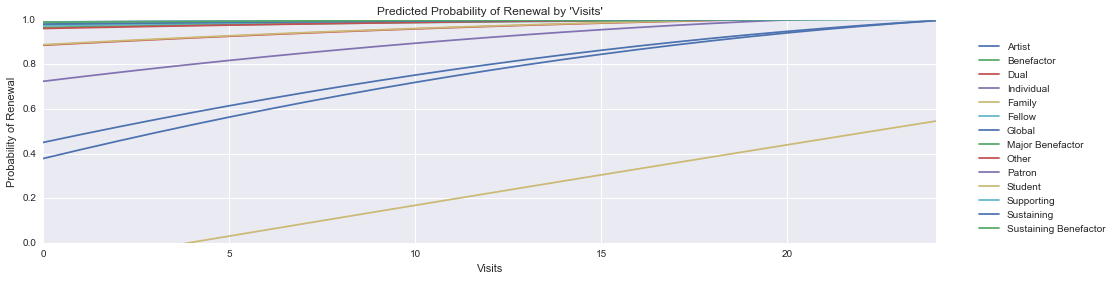

In [191]:
cat_table(member_data['Scanned_Visits'],'Visits')

#### Five Dollar Guest Tickets and Renewal
Five dollar guest ticket sales show little or no relationship with predicted renewal for many categories of member. Some categories show a slight negative correlation, with the exception of Global members whose probability of renewal drops dramatically with every guest ticket sold. This points to the opportunistic phenomenom of members who get the full value of their membership in one visit, being less likely to renew. Global members often fall into this category.

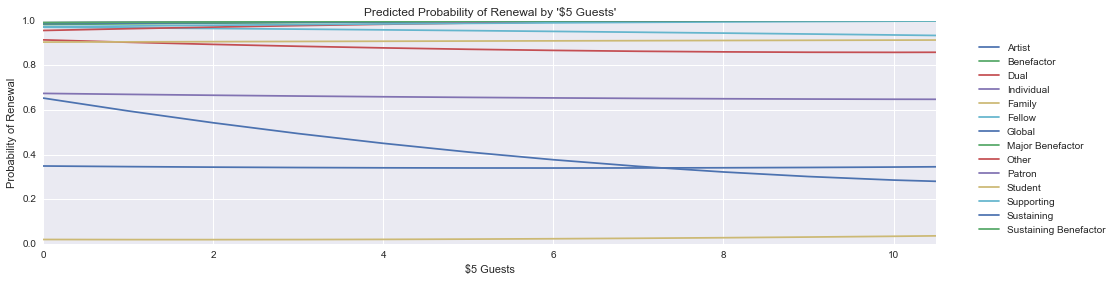

In [192]:
cat_table(member_data['Regular_Guests'], '$5 Guests')

#### Store Discount and Renewal
Store discount has a slightly negative correlation with renewal rate, but this varies greatly by category of member. With each member category priced differently, this again suggest opportunistic behaviour amongst lower level members.

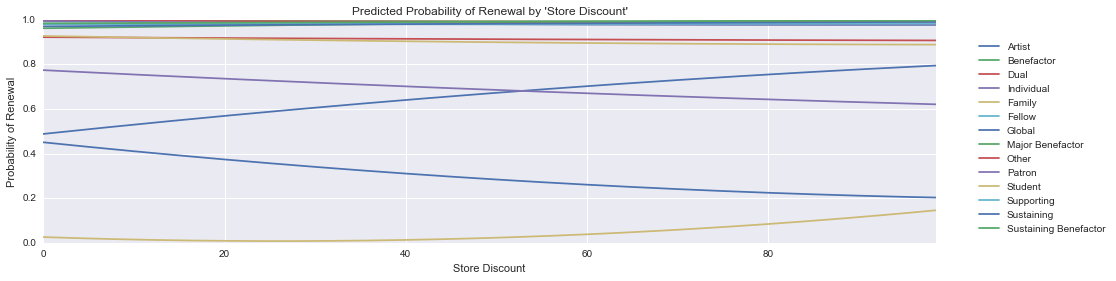

In [189]:
plot_table(member_data['Store_Discount'], 'Store Discount')

Creating a function to plot actual renewal rate against predicted, for different variables.

In [60]:
def actual_predicted_plot(index,title):
    plt.figure(figsize=(16,4))

    table1 = member_data.pivot_table(values=['Predicted'], index=index, aggfunc=np.mean)
    x = table1.index
    y = table1['Predicted']
    z = np.polyfit(x, y, 4)
    p = np.poly1d(z)
    pl.plot(x,p(x), "b-")
    pl.plot(x,p(x),label='Predicted')

    table2 = member_data.pivot_table(values=['Renewed'], index=index, aggfunc=np.mean)
    x = table2.index
    y = table2['Renewed']
    z = np.polyfit(x, y, 4)
    p = np.poly1d(z)
    pl.plot(x,p(x), "m-")
    pl.plot(x,p(x),label='Actual')

    plt.ylim(0,1)
    plt.xlim(table1.index.min(),table1.index.max())
    plt.title('Renewal Rate by %r' % title)
    plt.xlabel(title)
    plt.ylabel('Renewals')
    plt.legend(loc=4)    

#### Prediction versus Actual for Visits
After two visits, the model begins predicting higher levels of renewal than have actually happened. Most members will visit only twice, so past 3 visits there are very few data points on which to make predictions.

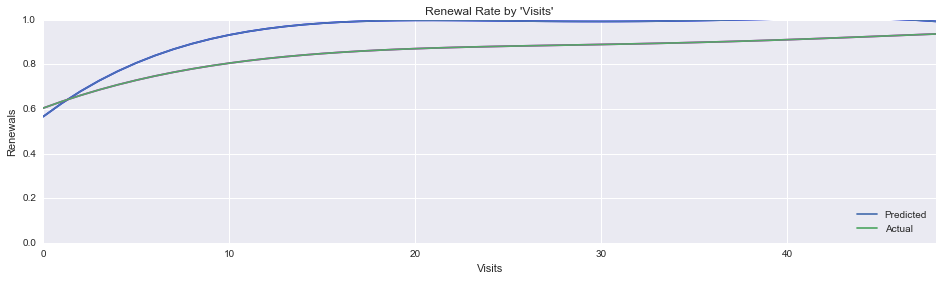

In [22]:
actual_predicted_plot(member_data['Scanned_Visits'],'Visits')

#### Predicting versus Actual for Guests
While the shape of the two plots is similar, after three five dollar tickets the model predicts lower renewal rates than have actually happened. The vast majority of people will not be buying more than four or five tickets, so there are not many data points on which to make predictions past the five mark. In general though, renewal rates decrease until three or four ticket sales and then start increasing again.

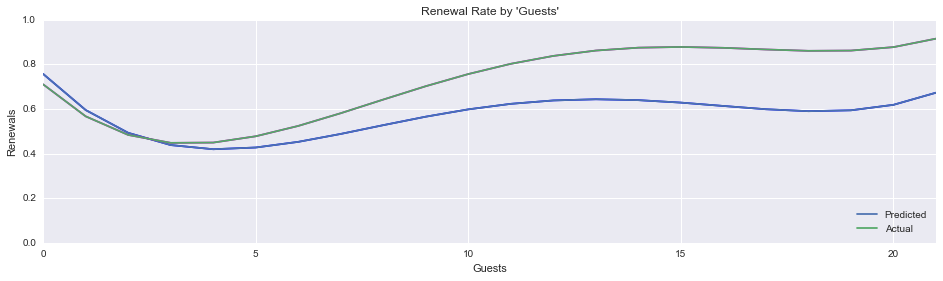

In [23]:
actual_predicted_plot(member_data['Regular_Guests'],'Guests')

#### Predicted versus Actual for Store Discount
The predicted and actual renewal rates are similar for store discount received, although predicted renewals are lower after about 45 dollars. Given that you would have to be spending about 400 dollars to receive this, there are not many data points on which to make predictions past the 50 dollar mark.

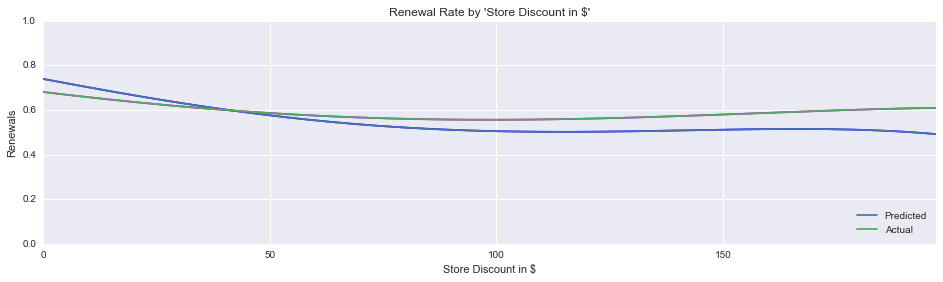

In [58]:
actual_predicted_plot(member_data['Store_Discount'],'Store Discount in $')

#### Predicted versus Actual for Year of Membership
The model predicts slightly higher levels of renewal for members that have been with the Museum for fewer than seven or eight years. There are many more examples of these members in the dataset than exist at any given time in, since the dataset is looking over a ten year period. This means that when predicting on a future group of members, this affect would not be so prominent.

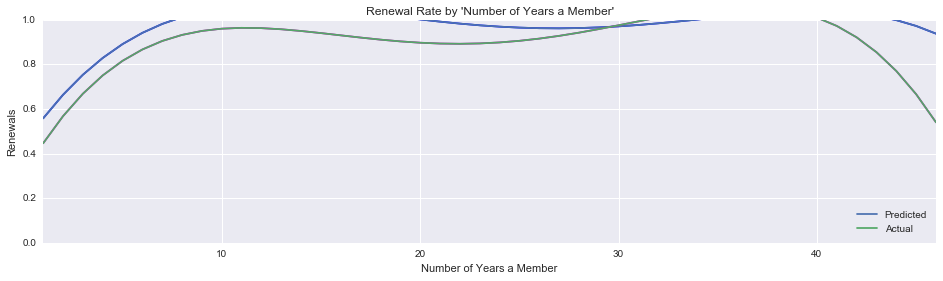

In [62]:
actual_predicted_plot(member_data['Member_Year'],'Number of Years a Member')

### Improvements to the Model
#### Improving the Model by Accurately Accounting for Opportunism
Opportunism has been an on-going theme throughout this study. To recap, this is a phenomenom where a member buys their membership and any guest passes they need purely because it is cheaper to do so than to buy the necessary admission tickets. Add store discount into the equation and many members are able to achieve the full value of their membership on day one. Such members are much less likely to renew.

While I attempted to identify this behaviour, my attempt was limited by the initial data collected in that it was aggregated by member contract. I created a variable for opportunism, where if a member had visited once only and the value of their membership plus guest tickets was less than what they would have to pay for admission the opportunism field was marked '1', otherwise '0'. This approach showed some success, but ultimately this new field was probably quite highly correlated with other variables and key model scores were not significantly changed.

A truer measure of opportunism would be to identify those members who get the full value of their membership on the day of membership sale, and to test this for correlation with other model variables. This approach would parallel that of the Ascarza and Hardie model discussed above.

#### Improving the Model by Grouping Guest Sales into Four Sections
An alternative approach to handling the issue of opportunism would be to deal with people who bought between 0 and 4 guest tickets differently to those who bought between 5 and 9, 10 and 14, etc. These groups could be handled as dummy variables and thus appear have different coefficients within the model.

#### Improving the Model by Reducing System Error
Some of the reporting systems that produce the dataset have limitations on how they report.

For example, the scan report will occasionally double count visits since it reports valid scans not unique scans. Dual, Family and high level member scans can be for multiple people, as opposed to the same person coming in twice in a day, so the report is designed to account for this.

Another example is film visits, where the same member could see multiple films on the same day, or could book tickets for screenings that they don't actually attend. This is a common occurance, and it is unclear what effect this would have on a member's proclivity to renew.

There might be other examples, so each such report should be optimized to produce the best type of data for inclusion in the model. 

### Conclusion
#### Aims
This project aimed to determine if it is possible to predict if a member will renew at the end of a given contract, based on their use of member benefits (free entry, $5 guest tickets, and store discount) during that contract, and the level and length of their membership.

#### Methodology
The LogisticRegression model was chosen and various combinations of variables were tested before settling on the following:
- Log_Year: the log transformation of number of member years (number of contracts)
- Scanned visits
- Member without card visits
- Film visits
- 5 dollar guest pass sales
- 5 dollar film guest pass sales
- Free guests of high level members
- Free promotion guests
- Store discount in dollars
- Category of membership (using dummy variables, dropping student as reference)

After fitting the model, calculating the probabilities and predictions for each observation, I produced the ROC curve, Precision Recall curve and calculated the various model scores.

The model was tested again, using different member category dummy variables as references, and dropping different variables to see if any of these changes improved the scores. A dummy classifier was also used to compare predictions to.

The model was then cross-validated over ten-folds and the resultant score averages were found to closely match those of the model.

Lastly a confusion matrix was produced and this led to a cost benefit analysis to help explain the results.

#### Findings
Length of membership (number of contracts) and category of membership were found to be the most significant predictors of renewal. Each year of membership was found to increase the odds of renewal by 1.2 (controlling for all other variables) and categories of membership increased odds of renewal by anywhere in a range of 2.47 (Artist) to 8.14 (Patron), using Student as the reference category.

Of the various member benefits, visiting also improved the odds of renewal by 1.1 (controlling for all other variables), but buying member guest tickets and store discount had a more complex relationship with renewal rate.

The general relationship guest tickets to renewals is to reduce the odds. This is most likely due to the phenomenom of opportunism, where visitor buy a membership plus guest tickets solely because this is cheaper than the equivalent admission tickets would be. Store discount acts in a similar way. Such members who have no further financial incentive to visit and bring guests are therefor less likely to renew.

After the five guest point, a members odds of renewal start to improve again. Since guest passes are limited to five per visit for many members, bring more than five guests requires more commitment to the Museum and more commitment means increased odds of renewal.

In [69]:
print model.summary()

                           Logit Regression Results                           
Dep. Variable:                Renewed   No. Observations:              1023460
Model:                          Logit   Df Residuals:                  1023437
Method:                           MLE   Df Model:                           22
Date:                Thu, 17 Mar 2016   Pseudo R-squ.:                  0.2310
Time:                        20:52:51   Log-Likelihood:            -5.0570e+05
converged:                       True   LL-Null:                   -6.5762e+05
                                        LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Log_Year                  1.2166      0.003    371.158      0.000         1.210     1.223
Scanned_Visits            0.0747      0.001     82.543      0.000         0.073     0.077
No_Card_

#### Scores
Model scores as follows:
- Accuracy: 0.76752
- AUC: 0.73302
- Precision: 0.81134
- Recall: 0.84242

#### Cost Benefit Analysis
Current practice is to send between 1 and 12 mail pieces per member, and no attempt to identify who is likely to renew or lapse. A mail pieces costs about 93 cents. Student and Artist members (just over 5% of members) only get e-mail renewal reminders, these cost just 0.02 cents.

Application of the model could be to identify who is likely to lapse and send them just e-mail reminders. This way any false negatives would still get reminders, but they would be at a lower cost to the Museum. There is a chance that some members might not renew if all they receive is a few e-mails. Spending on false positives on the other hand, could also be reduced because the model balances precision with recall by being optimized for AUC score.

The value to the Museum of a member contract was calculated as $153.39.

Summary of cost benefit analysis
- Predicted Cost Benefits: 14,655,198.72
- Current Cost Benefit:    14,469,691.35
- Potential Saving:           185,507.37

#### Future Work
The model could be improved in at least three ways:
- Accurately accounting for opportunism by identifying those members who get the full value of their membership on the day of membership sale.
- Grouping guest sales into four sections dealing with people who bought between 0 and 4 guest tickets differently to those who bought between 5 and 9, 10 and 14, etc. These groups could be handled as dummy variables and thus appear have different coefficients within the model.
- Verifying that each report that contributed to the dataset was accurate and never double counting.

In [70]:
members_file_out = (r'members.csv')
member_data.to_csv(members_file_out, index = False)